# Example - 74 - Uranus Aerocapture - Part 3

In this example we illustrate the selection of a equilibrium glide guidance parameters and setting up a Monte Carlo simulation for aerocapture at Uranus.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from AMAT.planet import Planet
from AMAT.vehicle import Vehicle

Set up a Planet object for Uranus.

In [2]:
planet = Planet('URANUS')
planet.loadAtmosphereModel('../atmdata/Uranus/uranus-gram-avg.dat', 0 , 1 ,2, 3, heightInKmFlag=True)
planet.h_skip = 1000.0E3
planet.h_low  = 120e3
planet.h_trap = 100e3

Set up a vehicle object. Set the intitial state based on the discussion in ```example-72-uranus-aerocapture-part-2```

In [3]:
vehicle=Vehicle('Titania', 3000.0, 200.0 , 0.36, np.pi*4.5**2.0, 0.0, 1.125, planet)
vehicle.setInitialState(1000.0,-80.95,25.22,27.5946,132.066,-13.0 ,0.0,0.0)
vehicle.setSolverParams(1E-6)

Compute the parameters used in the equilibrium glide aerocapture guidance algorithm following Cerimele and Gamble. ```A Simplified Guidance Algorithm for Lifting Aeroassist Orbital Transfer Vehicles,” in 23rd Aerospace Sciences Meeting, Houston, TX, 1985, p. 348. doi: 10.2514/6.1985-348.``` Propogate the entry for a few seconds to compute the dynamic pressure profile during entry, and compute a linear fit: ```q = ah + b```.

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


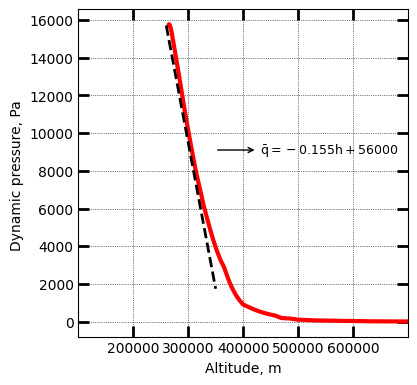

In [4]:
vehicle.propogateEntry2(200, 0.1, 0)

# Values for -13.64 deg, these are the linear fit 
# y = ax + b parameters used to compute Ghdot and Gq (see refs.)
a = -0.155
b =  56000

x_arr = np.linspace(260.0E3,350.0E3,101)
y_arr = a*x_arr + b

fig = plt.figure()
fig.set_size_inches([4.25,4.25])
plt.rc('font',family='Times New Roman')
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

plt.plot(vehicle.h_kmc*1E3,vehicle.dyn_pres_atm*1.01325E5,'r-',linewidth=3.0)

plt.xlim(100.0E3, 700.0E3)
#plt.ylim(0.0,12500.0)

plt.plot(x_arr,y_arr,color='k',linewidth=2.0,linestyle='dashed')
plt.xlabel("Altitude, m", fontsize=10)
plt.ylabel("Dynamic pressure, Pa ",fontsize=10)

plt.xticks(np.array([200.0E3 ,300E3, 400.00E3,  500e3, 600.0E3]),fontsize=10)

ax=plt.gca()
ax.tick_params(direction='in')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(axis='x',labelsize=10)
ax.tick_params(axis='y',labelsize=10)
ax.tick_params(direction='in')

ax.xaxis.set_tick_params(direction='in', which='both')
ax.yaxis.set_tick_params(direction='in', which='both')
ax.xaxis.set_tick_params(width=2, length=8)
ax.yaxis.set_tick_params(width=2, length=8)
ax.xaxis.set_tick_params(width=1, length=6, which='minor')
ax.yaxis.set_tick_params(width=1, length=6, which='minor')
ax.xaxis.grid(which='major', color='k', linestyle='dotted', linewidth=0.5)
ax.xaxis.grid(which='minor', color='k', linestyle='dotted', linewidth=0.0)
ax.yaxis.grid(which='major', color='k', linestyle='dotted', linewidth=0.5)
ax.yaxis.grid(which='minor', color='k', linestyle='dotted', linewidth=0.0)

ax.annotate(r'$\bar{q} = -0.155h + 56000$',
    xy=(348586, 9103.4) ,
    xytext=(431181, 9103.4),
    arrowprops=dict(arrowstyle="<-"),  va="center", ha="left", fontsize=9)

plt.show()

From the above, a = -0.155, b = 56000. Following Cerimel and Gamble (1985)

\begin{equation}
\label{eq:omega}    
{\omega_n}^2 = -\frac{C_L S}{m} G_{\bar{q}} a
\end{equation}

\begin{equation}
\label{eq:zeta}    
2 \zeta {\omega_n} = \frac{C_L S}{m} G_{\dot{h}}
\end{equation}

Using $\omega_n$ = 0.05, and $\zeta$ = 1.5, $G_{\bar{q}}$ and $G_{\dot{h}}$ are computed as follows

In [5]:
0.05**2*200/(0.36*0.155)

8.960573476702512

In [6]:
2*1.5*0.05*200/0.36

83.33333333333334

The vehicle initial state (other than the EFPA) is easy to set from the approach trajectory result. 

The selection of the target EFPA is a slightly tricky problem. A first estimate of the target EFPA is available from ```example-72-uranus-aerocapture-part-2```. We assume the approach navigation is able to deliver a 1-sigma EFPA error of 0.1667 deg, or 0.50 deg (3-sigma). The EFPA must be chosen such that the (target value - 3-sigma) should be able to capture in the expected thin atmosphere (nominal density - 3-sigma), and the (target value + 3-sigma) should not result in considerable apoapsis undershoot in case of thick atmosphere (nominal density + 3-sigma). For this example, we choose a target EFPA = -12.80 deg. This puts the -3-sigma EFPA at -12.30 deg, providing some margin (0.27 deg.) against escape in case of shallow entry combined with thin atmosphere. At the other end, the +3-sigma EFPA is -13.30 deg which also provides some margin (0.65 deg) against apoapsis undershoot in case of steep entry and thick atmosphere. 

In [7]:
vehicle=Vehicle('Titania', 3000.0, 200 , 0.36, np.pi*4.5**2.0, 0.0, 1.125, planet)
vehicle.setInitialState(1000.0,-80.95,25.22,27.5946,132.066,-12.80 ,0.0,0.0)
vehicle.setSolverParams(1E-6)
# Set the guidance parameters described in the paper.
# See the function description for parameter details.

# Set max roll rate constraint to 30 deg/s
vehicle.setMaxRollRate(30.0)

# Set Ghdot = 83
# Set Gq = 9.0
# Set v_switch_kms = 16.0 :: this parameter is not really used, and should just be set to low value
# Set low_Alt_km = 120
# Set numPoints_lowAlt = 101
# Set hdot_threshold = -500 m/s
vehicle.setEquilibriumGlideParams(83.0, 9.0, 16.0, 120.0, 101, -500.0)

# Set target orbit parameters
# periapsis = 4000.0 km
# apoapsis = 550,000 km :: set slightly above target (500e3) to account for bias in targeting algorithm
# apoapsis tolerance = 10 km
vehicle.setTargetOrbitParams(4000.0, 550.0E3, 10.0E3)

In [8]:
# Set path to atmfiles with randomly perturbed atmosphere files.
atmfiles = ['../atmdata/Uranus/perturbed/G-01.txt',
            '../atmdata/Uranus/perturbed/G-02.txt',
            '../atmdata/Uranus/perturbed/G-03.txt',
            '../atmdata/Uranus/perturbed/G-04.txt',
            '../atmdata/Uranus/perturbed/G-05.txt']

In [9]:
vehicle.setupMonteCarloSimulation(1201, 200, atmfiles, 0, 1, 2, 3, 4, True, \
                                 -12.80, 0.1667, 0.36, 0.013, 0.5, 0.1, 2400.0)

Propogate 100 guided trajectories.

In [10]:
vehicle.runMonteCarlo2(100, '../data/uranus2022/MCBX1')

RUN #: 1, SAMPLE #: 180, EFPA: -12.55, SIGMA: -0.83, LD: 0.36, APO : 524027.02
RUN #: 2, SAMPLE #: 5, EFPA: -12.68, SIGMA: 0.44, LD: 0.35, APO : 478167.79
RUN #: 3, SAMPLE #: 73, EFPA: -12.73, SIGMA: -1.82, LD: 0.37, APO : 513511.78
RUN #: 4, SAMPLE #: 77, EFPA: -12.87, SIGMA: -0.10, LD: 0.37, APO : 534446.41
RUN #: 5, SAMPLE #: 149, EFPA: -13.08, SIGMA: -0.65, LD: 0.38, APO : 490116.72
RUN #: 6, SAMPLE #: 100, EFPA: -12.83, SIGMA: -0.51, LD: 0.36, APO : 519722.91
RUN #: 7, SAMPLE #: 135, EFPA: -12.58, SIGMA: -1.75, LD: 0.37, APO : 513747.29
RUN #: 8, SAMPLE #: 4, EFPA: -12.69, SIGMA: 0.58, LD: 0.35, APO : 507983.07
RUN #: 9, SAMPLE #: 105, EFPA: -12.83, SIGMA: -1.48, LD: 0.37, APO : 503749.90
RUN #: 10, SAMPLE #: 98, EFPA: -12.73, SIGMA: -1.31, LD: 0.37, APO : 493052.87
RUN #: 11, SAMPLE #: 118, EFPA: -13.03, SIGMA: -0.68, LD: 0.37, APO : 494389.86
RUN #: 12, SAMPLE #: 119, EFPA: -12.99, SIGMA: 1.81, LD: 0.37, APO : 491178.05
RUN #: 13, SAMPLE #: 156, EFPA: -12.83, SIGMA: -0.42, LD: 0

In [12]:
p1  = np.loadtxt('../data/uranus2022/MCBX1/terminal_periapsis_arr.txt')
x1  = np.loadtxt('../data/uranus2022/MCBX1/terminal_apoapsis_arr.txt')
y1  = np.loadtxt('../data/uranus2022/MCBX1/acc_net_g_max_arr.txt')
z1  = np.loadtxt('../data/uranus2022/MCBX1/q_stag_max_arr.txt')
h1  = np.loadtxt('../data/uranus2022/MCBX1/heatload_max_arr.txt')
u1  = np.loadtxt('../data/uranus2022/MCBX1/periapsis_raise_DV_arr.txt')
v1  = np.loadtxt('../data/uranus2022/MCBX1/apoapsis_raise_DV_arr.txt')

Plot apoapsis historgram and apoapsis vs periapsis (before periapsis raise maneuver)

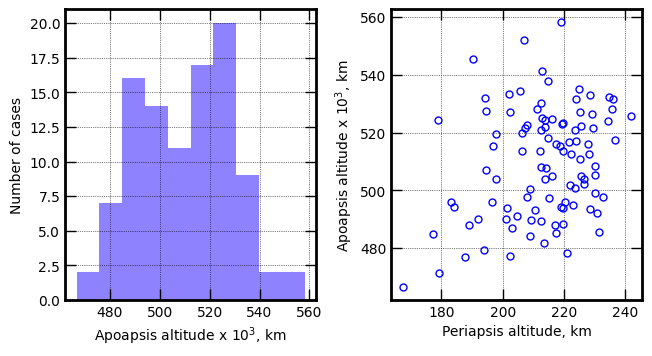

In [23]:
fig, axes = plt.subplots(1, 2, figsize = (6.5, 3.5))
fig.tight_layout()
plt.subplots_adjust(wspace=0.30)

axes[0].hist(x1/1000.0, bins=10, color='xkcd:periwinkle')
axes[0].set_xlabel('Apoapsis altitude x '+r'$10^3$'+', km', fontsize=10)
axes[0].set_ylabel('Number of cases', fontsize=10)

axes[0].tick_params(direction='in')
axes[0].yaxis.set_ticks_position('both')
axes[0].xaxis.set_ticks_position('both')
axes[0].tick_params(axis='x',labelsize=10)
axes[0].tick_params(axis='y',labelsize=10)


axes[1].plot(p1, x1/1000.0, 'bo', markersize=5, mfc='None')

axes[1].set_xlabel('Periapsis altitude, km',fontsize=10)
axes[1].set_ylabel('Apoapsis altitude x '+r'$10^3$'+', km', fontsize=10)


axes[1].tick_params(direction='in')
axes[1].yaxis.set_ticks_position('both')
axes[1].xaxis.set_ticks_position('both')
axes[1].tick_params(axis='x',labelsize=10)
axes[1].tick_params(axis='y',labelsize=10)

for ax in axes:
    ax.xaxis.set_tick_params(direction='in', which='both')
    ax.yaxis.set_tick_params(direction='in', which='both')
    ax.xaxis.set_tick_params(width=1, length=8)
    ax.yaxis.set_tick_params(width=1, length=8)
    ax.xaxis.set_tick_params(width=1, length=6, which='minor')
    ax.yaxis.set_tick_params(width=1, length=6, which='minor')
    ax.xaxis.grid(which='major', color='k', linestyle='dotted', linewidth=0.5)
    ax.xaxis.grid(which='minor', color='k', linestyle='dotted', linewidth=0.0)
    ax.yaxis.grid(which='major', color='k', linestyle='dotted', linewidth=0.5)
    ax.yaxis.grid(which='minor', color='k', linestyle='dotted', linewidth=0.0)
    
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(2)



plt.show()

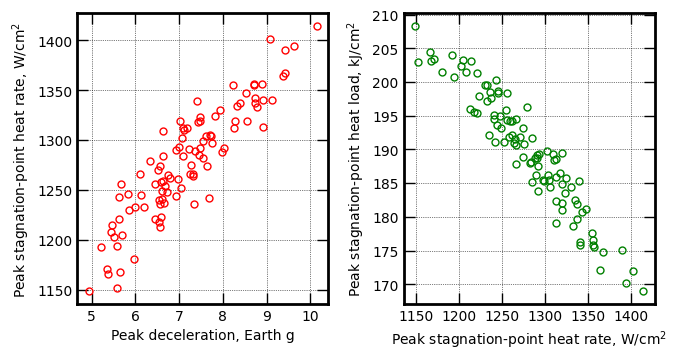

In [25]:
fig, axes = plt.subplots(1, 2, figsize = (6.5, 3.5))
fig.tight_layout()
plt.subplots_adjust(wspace=0.30)

axes[0].plot(y1, z1, 'ro', markersize=5, mfc='None')
axes[0].set_xlabel('Peak deceleration, Earth g', fontsize=10)
axes[0].set_ylabel('Peak stagnation-point heat rate, '+r'$W/cm^2$', fontsize=10)
axes[0].tick_params(direction='in')
axes[0].yaxis.set_ticks_position('both')
axes[0].xaxis.set_ticks_position('both')
axes[0].tick_params(axis='x',labelsize=10)
axes[0].tick_params(axis='y',labelsize=10)

axes[1].plot(z1, h1, 'go', markersize=5, mfc='None')
axes[1].set_xlabel('Peak stagnation-point heat rate, '+r'$W/cm^2$', fontsize=10)
axes[1].set_ylabel('Peak stagnation-point heat load, '+r'$kJ/cm^2$', fontsize=10)
axes[1].tick_params(direction='in')
axes[1].yaxis.set_ticks_position('both')
axes[1].xaxis.set_ticks_position('both')
axes[1].tick_params(axis='x',labelsize=10)
axes[1].tick_params(axis='y',labelsize=10)



for ax in axes:
    ax.xaxis.set_tick_params(direction='in', which='both')
    ax.yaxis.set_tick_params(direction='in', which='both')
    ax.xaxis.set_tick_params(width=1, length=8)
    ax.yaxis.set_tick_params(width=1, length=8)
    ax.xaxis.set_tick_params(width=1, length=6, which='minor')
    ax.yaxis.set_tick_params(width=1, length=6, which='minor')
    ax.xaxis.grid(which='major', color='k', linestyle='dotted', linewidth=0.5)
    ax.xaxis.grid(which='minor', color='k', linestyle='dotted', linewidth=0.0)
    ax.yaxis.grid(which='major', color='k', linestyle='dotted', linewidth=0.5)
    ax.yaxis.grid(which='minor', color='k', linestyle='dotted', linewidth=0.0)
    
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(2)

plt.show()

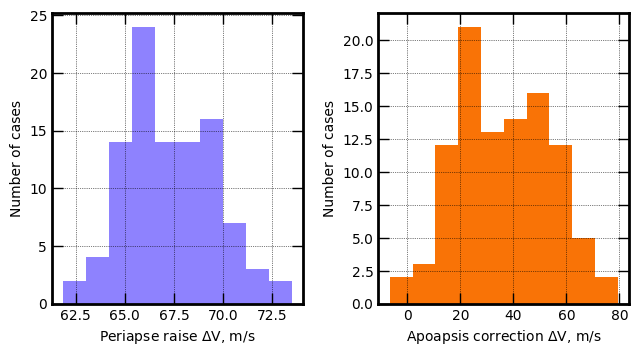

In [30]:
fig, axes = plt.subplots(1, 2, figsize = (6.5, 3.5))
fig.tight_layout()
plt.subplots_adjust(wspace=0.30)

axes[0].hist(u1, bins=10, color='xkcd:periwinkle')
axes[0].set_xlabel('Periapse raise '+r'$\Delta V$'+', m/s', fontsize=10)
axes[0].set_ylabel('Number of cases', fontsize=10)
axes[0].tick_params(direction='in')
axes[0].yaxis.set_ticks_position('both')
axes[0].xaxis.set_ticks_position('both')
axes[0].tick_params(axis='x',labelsize=10)
axes[0].tick_params(axis='y',labelsize=10)

axes[1].hist(v1, bins=10, color='xkcd:orange')
axes[1].set_xlabel('Apoapsis correction '+r'$\Delta V$'+', m/s', fontsize=10)
axes[1].set_ylabel('Number of cases', fontsize=10)
axes[1].tick_params(direction='in')
axes[1].yaxis.set_ticks_position('both')
axes[1].xaxis.set_ticks_position('both')
axes[1].tick_params(axis='x',labelsize=10)
axes[1].tick_params(axis='y',labelsize=10)



for ax in axes:
    ax.xaxis.set_tick_params(direction='in', which='both')
    ax.yaxis.set_tick_params(direction='in', which='both')
    ax.xaxis.set_tick_params(width=1, length=8)
    ax.yaxis.set_tick_params(width=1, length=8)
    ax.xaxis.set_tick_params(width=1, length=6, which='minor')
    ax.yaxis.set_tick_params(width=1, length=6, which='minor')
    ax.xaxis.grid(which='major', color='k', linestyle='dotted', linewidth=0.5)
    ax.xaxis.grid(which='minor', color='k', linestyle='dotted', linewidth=0.0)
    ax.yaxis.grid(which='major', color='k', linestyle='dotted', linewidth=0.5)
    ax.yaxis.grid(which='minor', color='k', linestyle='dotted', linewidth=0.0)
    
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(2)

plt.show()